# Estimation of Neurotransmitter Expression


This is the first notebook in the SSRI analysis project. The goal is to assign recorded neurons into groups which will be used in subsequent analyses. Specifically, we want to estimate which recorded neurons are likely 5HT-containing, and to subcategorise likely non-5HT-containg neurons into groups with similar spiking characteristics.

This analysis relies on previous research which suggests that the neurotransmitter-expressed by DRN neurons can be estimated from baseline firing rates, at least under urethane anaesthesia. Specifically DRN neurons that fire in a ...:

- ... slow and regular manner are likely to be 5HT-containing
- ... slow and irregular manner are likely to not be 5HT-containing
- ... fast rate are likely to be GABA-containing

Datasets exported:

- **baseline.csv** 

### Programming Frameworks
This Notebook uses the following frameworks

#### Data Import
- Data is stored in a local mysql server. A custom written (sqlalchemy-based) python package ephys_queries is used to write queries.
- DB credentials are stored in environment variables (using python-dotenv)

#### Spiketrain Analysis
- spiketimes pacakge

#### Clustering / Clasification
- sklearn

In [1]:
from ephys_queries import select_spike_times, select_ifr, select_waveforms, select_neurons
from ephys_queries import db_setup_core
from dotenv import load_dotenv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_palette("Set2")

In [3]:
from spiketimes.df import (
    mean_firing_rate_ifr_by_neuron, 
    cv2_isi_by_neuron,
    waveform_peaks_by_neuron, 
    waveform_width_by_neuron, 
    peak_asymmetry_by_neuron
)

/home/rory/miniconda3/envs/ssri/lib/python3.8/site-packages/elephant/pandas_bridge.py:21: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  warnings.warn("pandas_bridge module will be removed in Elephant v0.8.x",


## Clustering of Acute Data

Takes data from the **baseline period** of **treatment-naive** animals to assign each neurona type or label.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [5]:
import os

load_dotenv()
os.environ.get("DB_NAME")

'ephys'

### Select Raw Data

In [6]:
group_names = ["acute_citalopram", "acute_saline", "shock", 
               "sham", "acute_cit", "acute_sal"]
block_name = "pre"

load_dotenv()
engine, metadata = db_setup_core()

ifr = select_ifr(engine, metadata, 
                 block_name=block_name, 
                 group_names=group_names)
spiketimes = select_spike_times(engine, metadata, 
                                 block_name=block_name, 
                                 group_names=group_names)
waveforms = select_waveforms(engine, metadata,
                            group_names=group_names)
neurons = select_neurons(engine, metadata, group_names=group_names)

### Engineer Features

In [7]:
mfr = mean_firing_rate_ifr_by_neuron(ifr)
cv2 = cv2_isi_by_neuron(spiketimes, spiketimes_col="spike_time_samples")

peaks = waveform_peaks_by_neuron(waveforms, neuron_col="neuron_id", 
                         index_col="waveform_index", 
                         value_col="waveform_value").dropna()
width = waveform_width_by_neuron(peaks, peak_names=["initiation", "ahp"])
peak_asym = peak_asymmetry_by_neuron(peaks, peak_names=["initiation", "ahp"])

### Merge and Select Features For Clustering

In [8]:
df = pd.merge(mfr, cv2)  # dataset for clustering

df1 = pd.merge(df, width).pipe(lambda x: pd.merge(x, peak_asym))  # for later merging

### Apply Exclusion Criteria

In [9]:
df2 = df[df["mean_firing_rate"] > 0.5].copy()

### Apply Clustering

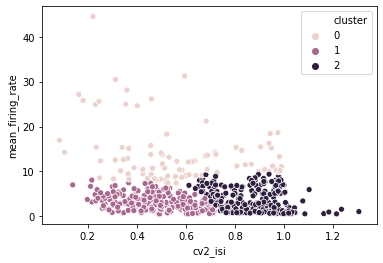

In [10]:
X = df2[["mean_firing_rate", "cv2_isi"]]
scaler = StandardScaler()
X = scaler.fit_transform(X)

model = GaussianMixture(3)
model.fit(X)
Y = model.predict(X)
df2["cluster"] = Y


sns.scatterplot(data=df2, x="cv2_isi", y="mean_firing_rate", hue="cluster")
plt.show()

### Add Cluster Labels

In [11]:
df2["cluster"] = df2.cluster.map({0: "fast_firing", 2: "slow_irregular", 1: "slow_regular"})

### Merge Data

In [12]:
df_acute = (df2
    .pipe(lambda x: pd.merge(x, df1, how="outer"))
    .pipe(lambda x: pd.merge(x, neurons, how="outer", left_on="neuron_id", right_on="id"))
)
               
df_acute["neuron_id"] = df_acute["neuron_id"].fillna(df_acute["id"])

df_acute = df_acute.drop(["recording_session_id", "cluster_id", "id"], axis=1)

df_acute["cluster"] = df_acute["cluster"].fillna("no_baseline")
df_acute.neuron_id = df_acute.neuron_id.astype(int)

## Classifying Chronic Data

Takes data from the **baseline period** of **treatment-receiving** animals to assign each neurona type or label.

In [13]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC

### Select Raw Data

In [15]:
group_names = ["citalopram_continuation", "chronic_saline", "citalopram_discontinuation", 
               "chronic_citalopram", "chronic_saline_"]
block_name = "pre"

engine, metadata = db_setup_core()

ifr = select_ifr(engine, metadata, 
                 block_name=block_name, 
                 group_names=group_names)
spiketimes = select_spike_times(engine, metadata, 
                                 block_name=block_name, 
                                 group_names=group_names)
waveforms = select_waveforms(engine, metadata,
                            group_names=group_names)
neurons = select_neurons(engine, metadata, group_names=group_names)

### Engineer Features

In [16]:
mfr = mean_firing_rate_ifr_by_neuron(ifr)
cv2 = cv2_isi_by_neuron(spiketimes, spiketimes_col="spike_time_samples")

peaks = waveform_peaks_by_neuron(waveforms, neuron_col="neuron_id", 
                         index_col="waveform_index", 
                         value_col="waveform_value").dropna()
width = waveform_width_by_neuron(peaks, peak_names=["initiation", "ahp"])
peak_asym = peak_asymmetry_by_neuron(peaks, peak_names=["initiation", "ahp"])

/home/rory/miniconda3/envs/ssri/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rory/miniconda3/envs/ssri/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Merge and Select Features For Clustering

In [17]:
df = pd.merge(mfr, cv2)
df1 = pd.merge(df, width).pipe(lambda x: pd.merge(x, peak_asym))  # for later merging

### Apply Exclusion Criteria

In [18]:
df2 = df[(df["mean_firing_rate"] > 0.5) & (df["cv2_isi"] < 1.2)].copy().dropna()

### Classify Data

In [19]:
df_acute2 = df_acute[df_acute["cluster"] != "no_baseline"]

y_train = df_acute2["cluster"].values
X_train = df_acute2[["mean_firing_rate", "cv2_isi"]].values

X_test = df2[["mean_firing_rate", "cv2_isi"]].values

le = LabelEncoder()
y_train = le.fit_transform(y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = SVC(kernel='rbf', C=1E6)
model.fit(X_train, y_train)

y_hat = model.predict(X_test)
df2["cluster"] = le.inverse_transform(y_hat) 

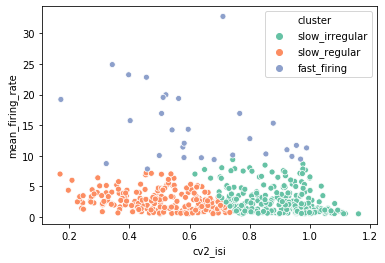

In [20]:
sns.scatterplot(data=df2, x="cv2_isi", y="mean_firing_rate", hue="cluster")
plt.show()

### Merge Data

In [21]:
df_chronic_baseline = (df2
    .pipe(lambda x: pd.merge(x, df1, how="outer"))
    .pipe(lambda x: pd.merge(x, neurons, how="outer", left_on="neuron_id", right_on="id"))
)
df_chronic_baseline["neuron_id"] = df_chronic_baseline["neuron_id"].fillna(df_chronic_baseline["id"])
df_chronic_baseline["cluster"] = df_chronic_baseline["cluster"].fillna("no_baseline")
df_chronic_baseline = df_chronic_baseline.drop(["recording_session_id", "cluster_id", "id"], axis=1)

df_chronic_baseline.neuron_id = df_chronic_baseline.neuron_id.astype(int)

## Merge Acute and Chronic then Save


In [22]:
data_dir = Path(".").absolute().parent / "data"
data_dir.mkdir(exist_ok=True)


df_baseline = pd.concat([df_acute, df_chronic_baseline])
df_baseline.to_csv(data_dir / "baseline.csv", index=False)